<b>The goal of this project is to build a personalized book recommender and use its engine to explore tastes of book readers. I will demonstrate how this tool can be used to improve performances of online bookstores. To do this, I will use a file books.csv which contains a list of books, with book_id, title and authors. Another file I will use it ratings.csv which contains a list of user votes, including user id, book_id and user rating of
the book (between 1 and 5).</b>

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE

In [2]:
filepath = Path('/Users/dannystatland/Drive/MBA/machine_learning/ex2')
ratings = pd.read_csv(filepath.joinpath('ratings.csv'))
books = pd.read_csv(filepath.joinpath('books.csv'))

In [64]:
books.head()

,book_id,authors,original_publication_year,original_title,language_code
0,0,Suzanne Collins,2008.0,The Hunger Games,eng
1,1,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng
2,2,Stephenie Meyer,2005.0,Twilight,en-US
3,3,Harper Lee,1960.0,To Kill a Mockingbird,eng
4,4,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng


Now I will use Latent Dirichlet Allocation (LDA) algorithm to create vector 
representation of each book, using gensim implementation:

In [4]:
corpus = csr_matrix((np.array(ratings.rating), (np.array(ratings.book_id), np.array(ratings.user_id))), shape=(books.shape[0], ratings.shape[0]))


In [5]:
def ApplyLDA(corpus):
    lda = LatentDirichletAllocation(n_components=10, n_jobs=-1, verbose=1, random_state=42, max_iter=70).fit(corpus)
    return pd.DataFrame(lda.transform(corpus), index=books.original_title)


In [6]:
df = ApplyLDA(corpus)

iteration: 1 of max_iter: 70
iteration: 2 of max_iter: 70
iteration: 3 of max_iter: 70
iteration: 4 of max_iter: 70
iteration: 5 of max_iter: 70
iteration: 6 of max_iter: 70
iteration: 7 of max_iter: 70
iteration: 8 of max_iter: 70
iteration: 9 of max_iter: 70
iteration: 10 of max_iter: 70
iteration: 11 of max_iter: 70
iteration: 12 of max_iter: 70
iteration: 13 of max_iter: 70
iteration: 14 of max_iter: 70
iteration: 15 of max_iter: 70
iteration: 16 of max_iter: 70
iteration: 17 of max_iter: 70
iteration: 18 of max_iter: 70
iteration: 19 of max_iter: 70
iteration: 20 of max_iter: 70
iteration: 21 of max_iter: 70
iteration: 22 of max_iter: 70
iteration: 23 of max_iter: 70
iteration: 24 of max_iter: 70
iteration: 25 of max_iter: 70
iteration: 26 of max_iter: 70
iteration: 27 of max_iter: 70
iteration: 28 of max_iter: 70
iteration: 29 of max_iter: 70
iteration: 30 of max_iter: 70
iteration: 31 of max_iter: 70
iteration: 32 of max_iter: 70
iteration: 33 of max_iter: 70
iteration: 34 of ma

Now I will use the vectors I obtained from the LDA to find similar books:

In [7]:
def GetSimilar(df, book, n_books):
    return df.apply(lambda x: cosine_similarity(x.values.reshape(1, -1), df.loc[book, :].values.reshape(1, -1))[0][0], axis=1).sort_values(ascending=False).iloc[1:n_books]


In [8]:
GetSimilar(df, "Harry Potter and the Philosopher's Stone", 10)


original_title
Harry Potter and the Deathly Hallows         0.990030
Harry Potter and the Goblet of Fire          0.989645
Harry Potter and the Order of the Phoenix    0.988907
Harry Potter and the Chamber of Secrets      0.988370
Harry Potter and the Prisoner of Azkaban     0.988310
Harry Potter and the Half-Blood Prince       0.987894
Go the Fuck to Sleep                         0.983928
Complete Harry Potter Boxed Set              0.963015
The Miracle of Forgiveness                   0.962597
dtype: float64

In [9]:
GetSimilar(df, "A Song of Ice and Fire", 10)


original_title
The Ruins                                            0.996778
A Clash of Kings                                     0.992297
The Green Mile                                       0.989712
Anne Rice's The Vampire Lestat: The Graphic Novel    0.989614
The Stand                                            0.989591
Dexter in the Dark                                   0.989006
Dearly Devoted Dexter                                0.988775
Boy's Life                                           0.987990
The Forest House                                     0.987732
dtype: float64

In the two books chosen for demonstration, we can see the algorithm is working not so bad for the first book - at the Harry Potter example, most of the recommendations were for the other Harry Potter book series (though it missed some), but for A Song of Ice and Fire the algorithm missed all but one (A Clash of Kings) books in the series. Even if the other recommended books are from the same genre, it makes more sense to recommend other books in the same series of books.

I will now apply a dimensionality reduction algorithm to find out whether the user tastes are
grouped into distinct clusters:

In [22]:
def GetDfReducedTo2D(df):
    user_taste_clusters = pd.Series(np.argmax(df.values, axis=1))
    return user_taste_clusters

In [23]:
user_taste_clusters = GetDfReducedTo2D(df)

    plt.subplots()
    tsne = TSNE(n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(df)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=user_taste_clusters, s=5, alpha=0.5)
    plt.title('Two Dimensional TSNE')
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    return plt

/Users/dannystatland/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/dannystatland/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


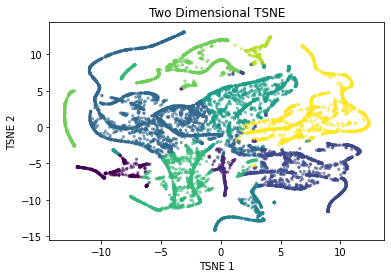

In [24]:
PlotTSNE().show()

We can see from the TSNE that there are clusters that show us the existence of relationships between observations and variables, and among the variables. To be more specific, in the TSNE we can observe distinct clusters which represent different book groups clustered by users rating. Online book stores can use such tools to recommend to a specific buyer purchase other books from the same cluster, thus enhancing the chances the user would buy them. Moreover, this data can be used to recommend to a new customer a book based on a combination of characteristics such as gender, age and geographical area which can be correlated to some clusters more than to others. Such steps may optimize store marketing efforts, as well as increase its revenues.

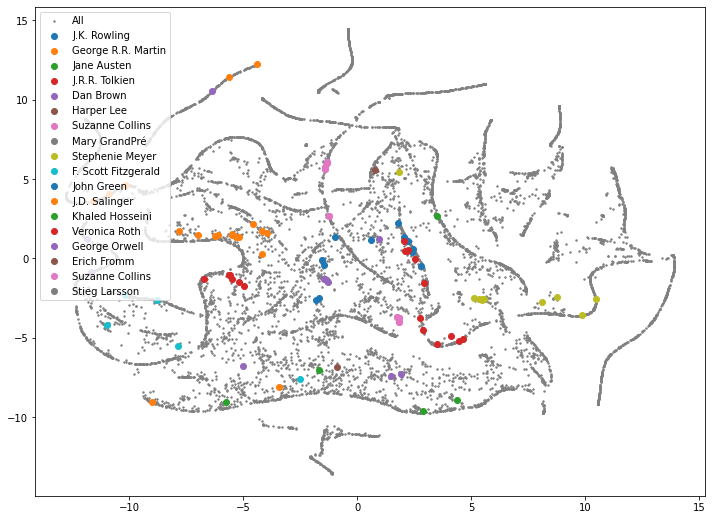

In [61]:
authors = ['J.K. Rowling', 'George R.R. Martin', 'Jane Austen', 
           'J.R.R. Tolkien', 'Dan Brown', 'Harper Lee', 'Suzanne Collins',
           'Mary GrandPré', 'Stephenie Meyer', 'F. Scott Fitzgerald',
           'John Green', 'J.D. Salinger', 'Khaled Hosseini', 'Veronica Roth',
           'George Orwell', 'Erich Fromm', 'Suzanne Collins', 'Stieg Larsson']

plt.figure(figsize=(12,9))
plt.scatter(tsne[:,0],tsne[:,1], label='All',c='grey', s=2, cmap='prism')

for author in authors: 
    book_index = np.array(books.index[(books['authors']== author)])
    plt.scatter(tsne[book_index,0],tsne[book_index,1], label='{}'.format(author), cmap='prism')
plt.legend(loc='upper left')
plt.show()   

We can see from this sample that some authors are clustered together, hence, we can recommend to a customer who bought a book of George R.R Martin to buy a book of J.D. Salinger for instance. 

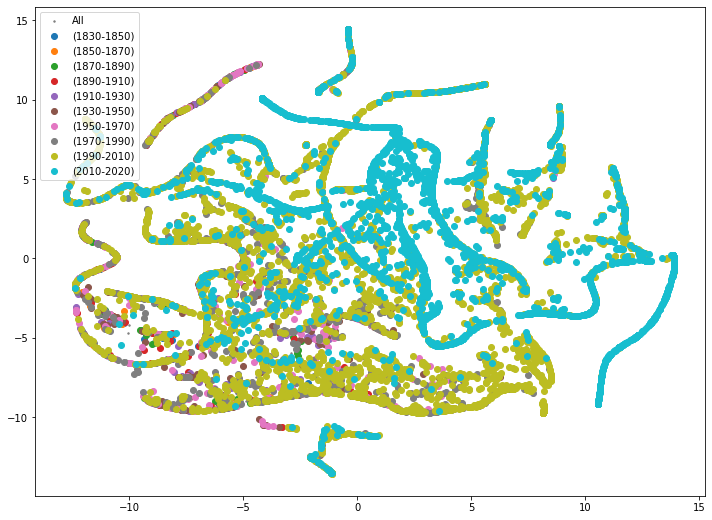

In [66]:
decades = [(1830,1850),(1850,1870), (1870,1890),
         (1890,1910),(1910,1930),(1930,1950),(1950,1970), (1970,1990),
         (1990,2010),(2010,2020)]

plt.figure(figsize=(12,9))
plt.scatter(tsne[:,0],tsne[:,1], label='All',c='grey', s=2, cmap='prism')

for first_decade, second_decade in decades: 
    book_index = np.array(books.index[(books['original_publication_year']>=first_decade) & (books['original_publication_year']<second_decade)])
    plt.scatter(tsne[book_index,0],tsne[book_index,1], label='({}-{})'.format(first_decade, second_decade), cmap='prism')
plt.legend(loc='upper left')
plt.show()   

We can see from this sample that books published between 1990-2010 are clustered separately from books published between 2010-2020, hence, we can recommend to a customer who bought a book published in 1990 to buy books published up till 2010.